This notebook is the final answer to the first of the two questions contained in NextCaller's Data Science Quiz (a blind machine learning problem). The answers are interleaved in the notebook below after some initial exploration of the data in question.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import time

%matplotlib notebook

# Exploring the Data

In [2]:
data = pd.read_table('Search_Data.txt')
data.head()

,ID,Feat 1,Feat 2,Feat 3,Feat 4,Label
0,1,10.526413,5.680796,1.661569,0.167528,Burnt Umber
1,2,15.023991,5.471672,0.897001,0.669878,Red
2,3,16.021447,-1.501333,1.902509,0.351208,Red
3,4,14.425902,6.429031,1.025405,0.528408,Aquamarine
4,5,11.547150,-4.699529,0.337308,0.011619,Red


In [3]:
data['Label'].value_counts()

Red            720
Aquamarine     220
Burnt Umber     60
Name: Label, dtype: int64

Let's break up the data into independent and dependent variables. Also, I'm going to refer to Burnt Umber as Orange for plotting purposes below.

In [4]:
X = data[['Feat 1','Feat 2','Feat 3','Feat 4']]
Y = data['Label']
Y[Y == 'Burnt Umber'] = 'Orange'

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


First, let's plot the relation between each variable to see if any clusters stand out. We normalize the data first to keep plotting axes consistent.

<IPython.core.display.Javascript object>


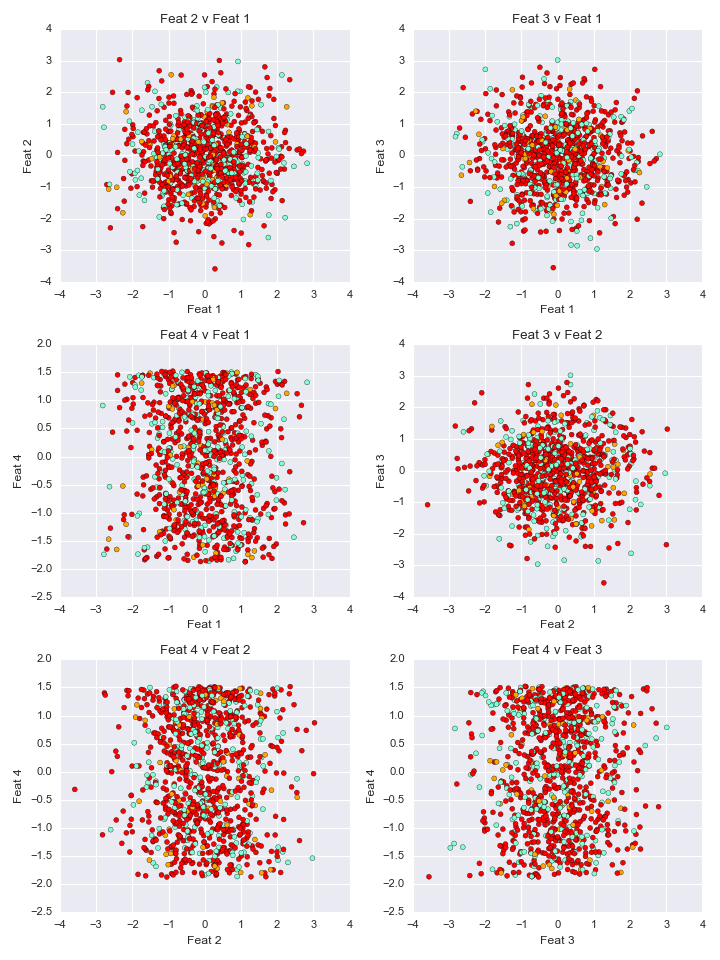

In [28]:
## create one big figure behind subpanels
fig, axes = plt.subplots(3,2,figsize=(9,12), facecolor='w')
pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
feats = ['Feat 1','Feat 2','Feat 3','Feat 4']

## scale data
standard_scaler = preprocessing.StandardScaler()
X_sc = standard_scaler.fit_transform(X)

## cycle through each pair of variables and show scatter plot
for ax, pair in zip(axes.reshape(-1),pairs):
    
    ax.scatter(X_sc[:, pair[0]], X_sc[:, pair[1]], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel(feats[pair[0]])
    ax.set_ylabel(feats[pair[1]])
    ax.set_title(feats[pair[1]] + ' v ' + feats[pair[0]])
    
    
plt.tight_layout()

Variables 1, 2 and 3 all look normally distributed with no correlation (as assessed by gunshot plots above), while Variable 4 looks like some kind of smooth distribution cutoff at -2 and 1.5 std devs for min and max respectively.

Let's show a similar plot for each of the types individually.

<IPython.core.display.Javascript object>


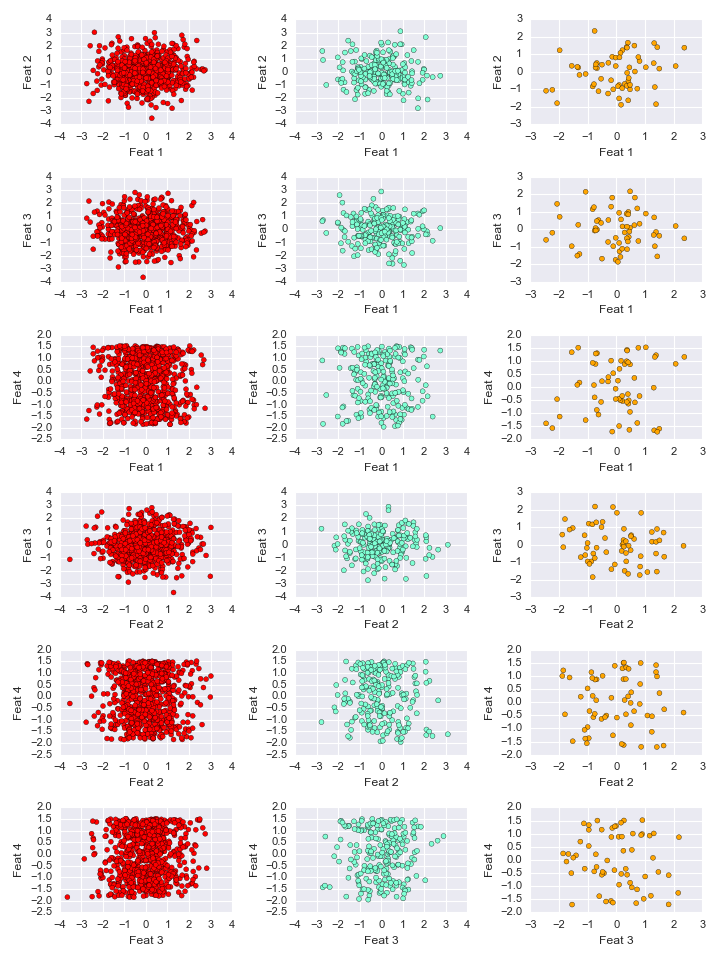

In [30]:
fig, axes = plt.subplots(6,3,figsize=(9,12), facecolor='w')

## create one big figure behind subpanels
pairs_list = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
pairs = [val for val in pairs_list for __ in range(3)]

df_red = data[data['Label'] == 'Red']
df_aqua = data[data['Label'] == 'Aquamarine']
df_umber = data[data['Label'] == 'Orange']

dflist = [df_red, df_aqua, df_umber]
dfindices = [0,1,2]*6

## cycle through each pair of variables and show scatter plot
for ax, pair, index in zip(axes.reshape(-1),pairs,dfindices):

    ## scale data
    X_color = dflist[index][['Feat 1','Feat 2','Feat 3','Feat 4']]
    standard_scaler = preprocessing.StandardScaler()
    X_color_sc = standard_scaler.fit_transform(X_color)
    ax.scatter(X_color_sc[:, pair[0]], X_color_sc[:, pair[1]], c=dflist[index]['Label'], edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel(feats[pair[0]])
    ax.set_ylabel(feats[pair[1]])
    #ax.set_title(feats[pair[1]] + ' v ' + feats[pair[0]])    
    
plt.tight_layout()

A closer inspection at the distribution of the features for each individual category fails to reveal any major differences between categories. Let's try one more way to explore the data using density plots instead of plotting each individual point.

In [35]:
#switch the category name back to its original
Y[Y == 'Orange'] = 'Burnt Umber'

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


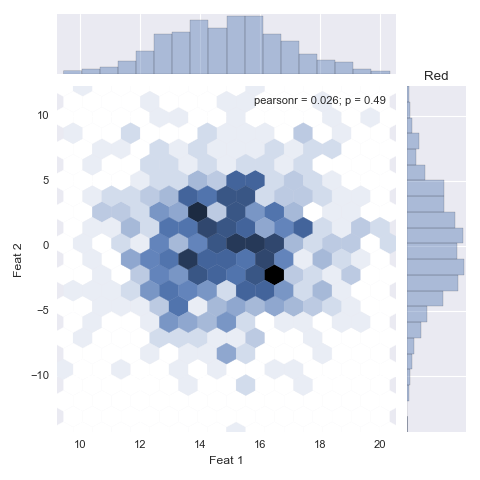

<IPython.core.display.Javascript object>


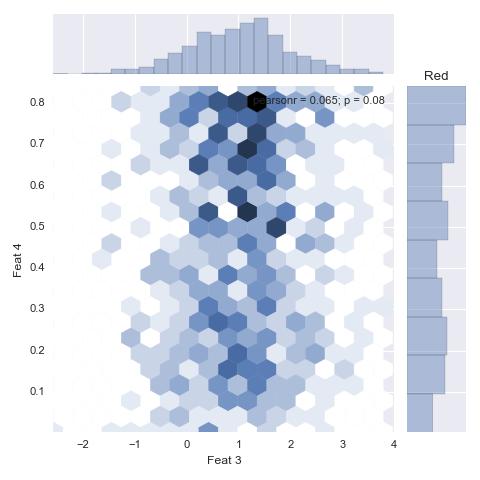

<IPython.core.display.Javascript object>


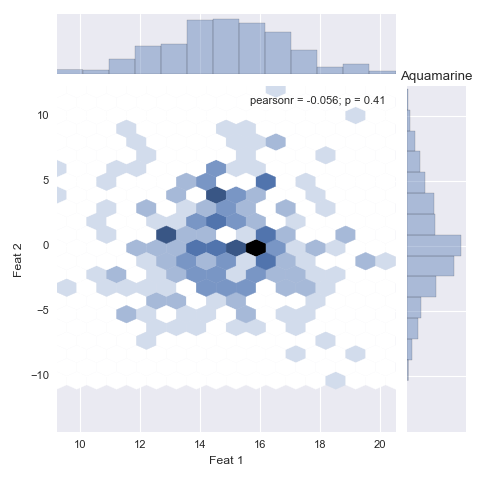

<IPython.core.display.Javascript object>


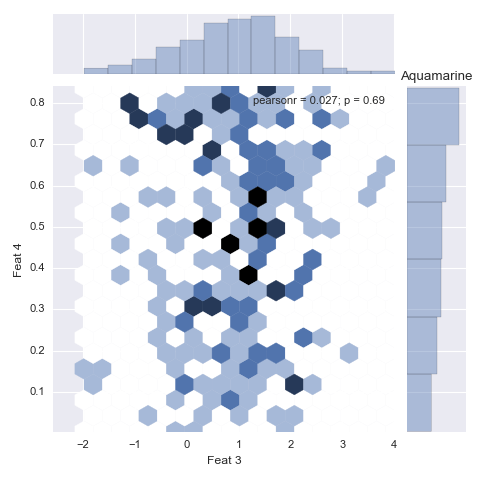

<IPython.core.display.Javascript object>


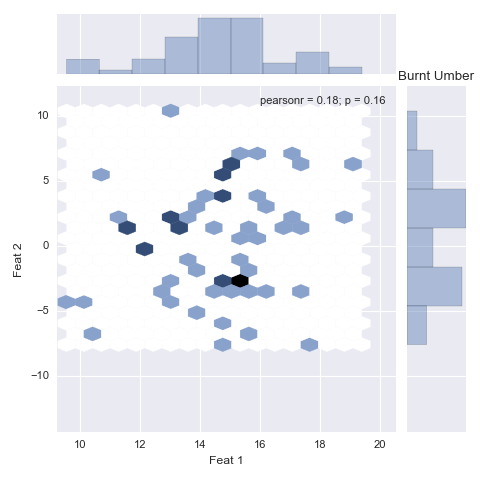

<IPython.core.display.Javascript object>


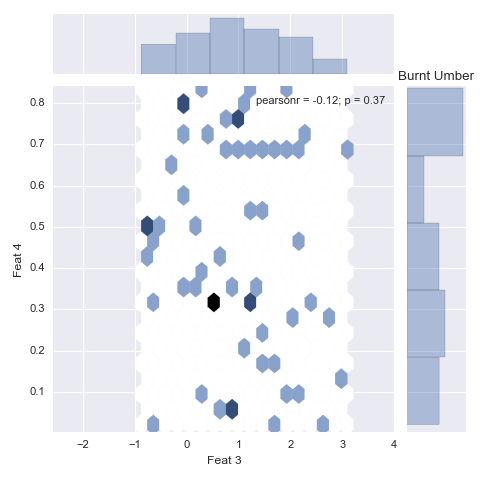

In [36]:
feats = [['Feat 1','Feat 2'],['Feat 3','Feat 4']]*3
df_red = data[data['Label'] == 'Red']
df_aqua = data[data['Label'] == 'Aquamarine']
df_umber = data[data['Label'] == 'Burnt Umber']
df_colors = [df_red,df_red,df_aqua,df_aqua,df_umber,df_umber]
colors = ['Red','Red','Aquamarine','Aquamarine','Burnt Umber','Burnt Umber']
xmin = [data['Feat 1'].min(),data['Feat 2'].min(),data['Feat 3'].min(),data['Feat 4'].min()]
xmax = [data['Feat 1'].max(),data['Feat 2'].max(),data['Feat 3'].max(),data['Feat 4'].max()]
xmin_plot = [xmin[0],xmin[2]]*3
ymin_plot = [xmin[1],xmin[3]]*3
xmax_plot = [xmax[0],xmax[2]]*3
ymax_plot = [xmax[1],xmax[3]]*3

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for i in range(6):
    sns.jointplot(x=feats[i][0], y=feats[i][1], data=df_colors[i], kind = 'hex', \
                  gridsize = [17,11], xlim=[xmin_plot[i],xmax_plot[i]], ylim = [ymin_plot[i],ymax_plot[i]])
    plt.title(colors[i])

From the distribution above, features 1, 2 and 3 really do look normal for all intents and purposes in both the Red and Aquamarine points. The Burnt Umber points are much fewer but also appear to be drawn from the same distribution. The distribution of feature 4 also looks pretty much the same between Red, Aquamarine and Burnt Umber points, but perhaps there is some bimodality in Feature 4 for the Burnt Umber that is absent from Aquamarine - would take a great deal more convincing.

I tried out some other hex plots in my scratch notebook but found nothing worth reporting, so I've omitted other hex plots here with 1v3/2v4 and 1v4/2v3.

Lastly, let's see if the numbers concur with the visual representations of the data above.

In [37]:
data.groupby('Label').describe()

Feat 1      Feat 2      Feat 3      Feat 4           ID
Label                                                                         
Aquamarine  count  220.000000  220.000000  220.000000  220.000000   220.000000
            mean    14.855971    0.245400    0.921365    0.475640   545.463636
            std      2.061649    3.830420    1.069576    0.241026   284.039861
            min      9.234888  -10.352880   -1.972700    0.004776     4.000000
            25%     13.563115   -2.144795    0.264810    0.274100   319.750000
            50%     14.889972   -0.102656    0.985837    0.492571   571.000000
            75%     16.181939    2.830191    1.664535    0.696206   774.500000
            max     20.503973   12.080668    4.012365    0.837411  1000.000000
Burnt Umber count   60.000000   60.000000   60.000000   60.000000    60.000000
            mean    14.553468    0.427304    0.951305    0.452606   540.466667
            std      2.055059    4.291880    0.992022    0.255030   318.406864
            min      9.561882   -7.590026   -0.872921    0.021129     1.000000
            25%     13.173389   -3.099117    0.265904    0.301460   271.000000
            50%     14.809979    1.273276    0.918067    0.459028   503.500000
            75%     15.522447    3.264899    1.638239    0.687479   856.500000
            max     19.378450   10.387722    3.095657    0.835528   991.000000
Red         count  720.000000  720.000000  720.000000  720.000000   720.000000
            mean    14.890096    0.041519    1.017993    0.463451   483.430556
            std      1.974222    4.070017    0.981846    0.248816   286.294805
            min      9.460855  -14.343677   -2.563343    0.002455     2.000000
            25%     13.492842   -2.707882    0.360407    0.243421   233.750000
            50%     14.943531   -0.076003    1.052036    0.481762   477.500000
            75%     16.269048    2.801496    1.605870    0.695670   735.500000
            max     20.306380   12.311362    3.785691    0.841278   997.000000